In [1]:
import io
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches
import cv2

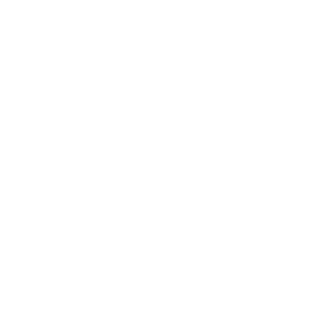

In [102]:
# Size of canvas
image_width = 64
image_height = 64
super_sampling_scale = 7
width = super_sampling_scale * image_width
height = super_sampling_scale * image_height

# Actual value of DPI does not matter for final output
# Larger value makes the matplotlib canvas smaller on screen
dpi = 100


# create a figure with fixed size
fig = plt.figure(frameon=False)
fig.set_size_inches(width/dpi, height/dpi)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.axis('off')
fig.add_axes(ax)

ax.set_xlim(0, width)
ax.set_ylim(0, height)

io_buf = io.BytesIO()

In [103]:
def draw_shape(shape, x=.5*width, y=.5*height, **kwargs):
    if shape == 'circle':
        patch = generate_circle(x, y, **kwargs)
    elif shape == 'triangle':
        patch = generate_triangle(x, y, **kwargs)
    else:
        raise ValueError(f"Invalid shape: {shape}")
    # keep reference to the patch connected to the axis so it can be removed later
    patch = ax.add_patch(patch)
    # extract data from image
    # taken from https://stackoverflow.com/questions/7821518/matplotlib-save-plot-to-numpy-array
    io_buf.seek(0)
    fig.savefig(io_buf, format='rgba', dpi=dpi)
    io_buf.seek(0)
    # load (flattened) image into numpy array, reshape, keep only one channel (R)
    img = np.frombuffer(io_buf.getvalue(), dtype=np.uint8).reshape(width, height, -1)[..., 0]

    # remove the patch from the axis
    patch.remove()
    return img

def generate_circle(x, y, radius):
    return patches.Circle((x, y), radius, fc='k', ec='k', antialiased=True)

def generate_triangle(x, y, radius, angle):
    a = rot(angle).dot(np.array([0, radius]))
    b = rot(120).dot(a)
    c = rot(120).dot(b)
    m = np.array([x,y])
    return patches.Polygon([a+m, b+m, c+m], closed=True, fill=True, antialiased=True)
    
def rot(angle_deg):
    angle = np.deg2rad(angle_deg)
    return np.array([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

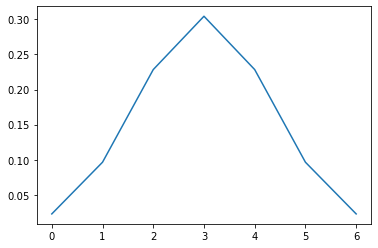

In [104]:
from scipy.stats import norm
def get_smoothing_kernel(super_sampling_scale):
    a = np.arange(super_sampling_scale).astype(float)
    a -= a.mean()
    a /= 0.66*a.std() 
    d = norm.pdf(a)
    d /= d.sum()
    return d

plt.plot(get_smoothing_kernel(7))

32it [00:00, 415.43it/s]
32it [00:00, 492.09it/s]


(64, 448, 448)
(64, 64, 64)


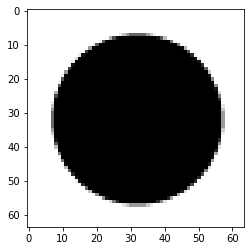

In [105]:
ncircle = 32
ntriangle = 32
shapes = np.empty(shape=(ncircle+ntriangle, height, width))

# circles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ncircle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    shapes[n] = draw_shape('circle', radius=radius)

# triangles
radii = np.random.uniform(.2*min(width, height), .48*min(width, height), ntriangle)
angles = np.random.uniform(0, 360, ntriangle)
for n, radius in tqdm.tqdm(enumerate(radii)):
    angle = angles[n]
    shapes[ncircle+n] = draw_shape('triangle', radius=radius, angle=angle)
    
# scale to 0-1
shapes = shapes.astype(float) / 255.
for i,_ in enumerate(shapes):
    shapes[i] = cv2.GaussianBlur(shapes[i], (super_sampling_scale, super_sampling_scale), 0.3*super_sampling_scale,0)

print(shapes.shape)
shapes = shapes[:,::super_sampling_scale,::super_sampling_scale] # NB! This causes the circle to shift by less than 1 pixel, but the result is not exactly centered.
print(shapes.shape)
plt.imshow(shapes[0], cmap='gray')

In [106]:
labels = np.zeros(ncircle+ntriangle, dtype=int)
# circle=0, triangle=1
labels[ncircle:] = 1

In [107]:
indices = np.random.choice(ncircle+ntriangle, size=ncircle+ntriangle, replace=False)
shapes = shapes[indices]
labels = labels[indices]

In [108]:
np.savez_compressed('shapes.npz', X=shapes, y=labels)

In [68]:
!du -hs shapes.npz

'du' is not recognized as an internal or external command,
operable program or batch file.


In [109]:
fd = np.load('shapes.npz')
X = fd['X']
y = fd['y']
fd.close()

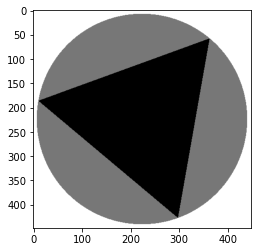

In [110]:
triangle = draw_shape('triangle', radius=.48*width, angle=40)
circle = draw_shape('circle', radius=.48*width)
data = (.5 * circle) + (.5 * triangle)

plt.figure()
plt.imshow(data, cmap='gray')

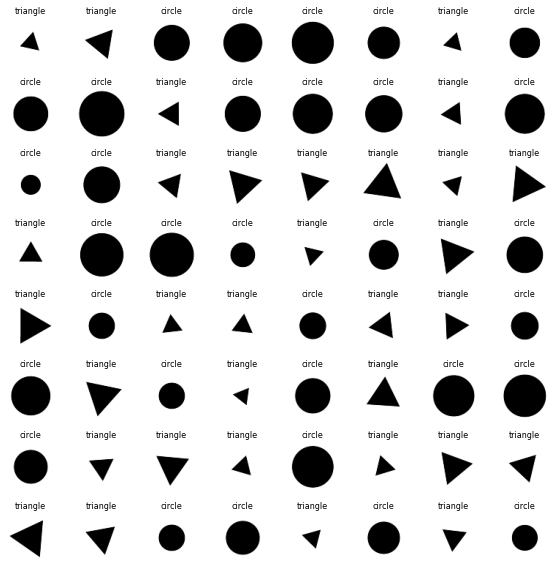

In [111]:
overview_fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(8, 8))
axes = axes.flatten()

classes = ['circle', 'triangle']

for i in range(64):
    a = axes[i]
    a.imshow(X[i], cmap='gray')
    a.set_title(classes[y[i]], fontsize=8)
    a.axis('off')
    
overview_fig.tight_layout()